# KCP Dataset PDF Cover Page Snapshot

In [1]:
%load_ext autotime

In [2]:
from wb_nlp import dir_manager

time: 134 ms


In [3]:
!/home/wb536061/anaconda3/envs/wb_nlp/bin/pip install pdf2image > /dev/null

time: 1.52 s


In [4]:
import requests
import json
import os
import time
import glob
from pathlib import Path
import pandas as pd
import re
from joblib import Parallel, delayed
import pdf2image
import PIL


time: 292 ms


In [5]:
class DocumentCover:
    def __init__(self, doc_id, cover_dir, pdf_path=None, pdf_url=None, fixed_width=200, fixed_height=None):
        self.doc_id = doc_id
        self.pdf_path = pdf_path
        self.pdf_url = pdf_url
        self.cover_dir = cover_dir
        self.fixed_width = fixed_width
        self.fixed_height = fixed_height

        # self.fname = os.path.join(self.cover_dir, f'{self.doc_id}.png')
        self.fname = self.cover_dir / f'{self.doc_id}.png'

        self.orig_cover = None
        self.cover = None
        self.resized = None

    def get_content_from_url(self):
        self.resized = False
        res = requests.get(self.pdf_url)

        try:
            pages = pdf2image.convert_from_bytes(res.content, size=(self.fixed_width, self.fixed_height), single_file=True)
            self.resized = True
        except:
            pages = pdf2image.convert_from_bytes(res.content)
            
        self.orig_cover = pages[0]

    def get_content_from_file(self):
        self.resized = False
        with open(self.pdf_path, "rb") as open_file:
            content = open_file.read()
            try:
                pages = pdf2image.convert_from_bytes(content, size=(self.fixed_width, self.fixed_height), single_file=True)
                self.resized = True
            except:
                pages = pdf2image.convert_from_bytes(content)

        self.orig_cover = pages[0]

    def standardize_size(self):
        # Not useful if `size` is set in pdf2image.convert_from_bytes
        c = self.orig_cover

        if c is None:
            if self.pdf_path:
                self.get_content_from_file()
            elif self.pdf_url:
                self.get_content_from_url()
            c = self.orig_cover
            assert(c)

        if not self.resized:
            width = self.fixed_width
            w0, h0 = c.size
            c = c.resize((width, int(h0 * width / w0)), resample=PIL.Image.BICUBIC)

        self.cover = c

    def save(self):
        if not os.path.isfile(self.fname):        
            cover = self.cover

            if cover is None:
                self.standardize_size()
                cover = self.cover

            cover.save(self.fname)

        return self.doc_id

    def cleanup(self):
        del(self.orig_cover)
        del(self.cover)

        self.orig_cover = None
        self.cover = None

time: 1.22 ms


In [6]:
corpus_path = Path(dir_manager.get_data_dir("corpus").replace("/home/", "/data/"))
CORPUS_DIRS = list(corpus_path.glob("*/PDF_ORIG"))

time: 1.11 ms


In [7]:
def prepare_meta(corpus_dir):
    data = []
    corpus_id = corpus_dir.parent.name.lower()

    for pdf in corpus_dir.glob("*.pdf"):
        metadata = {}

        metadata["id"] = f"{corpus_id}_{pdf.stem}"
        metadata["pdf_path"] = pdf.resolve()
        metadata["cover_dir"] = (corpus_dir.parent / "COVER").resolve()

        data.append(metadata)

    return data

time: 392 µs


In [8]:
def parallel_process(row):
    ret = dict(status='ok', doc_id=row['id'])
    try:
        dc = DocumentCover(doc_id=row['id'], cover_dir=row["cover_dir"], pdf_path=row["pdf_path"])
        r = dc.save()
        dc.cleanup()
    except Exception as e:
        ret['status'] = e.__str__()

    return ret

time: 333 µs


In [9]:
dataset = []
for corpus_dir in CORPUS_DIRS:
    if corpus_dir.parent.name == "IADB":
        continue
    COVER_DIR = corpus_dir.parent / "COVER"
    if not COVER_DIR.exists():
        COVER_DIR.mkdir(parents=True)

    dataset.extend(prepare_meta(corpus_dir))
len(dataset)

66701

time: 5.44 s


{'id': 'wfp_bca2ff164e383569b375bb42879a9f89e9688dda', 'pdf_path': PosixPath('/data/wb536061/wb_nlp/data/corpus/WFP/PDF_ORIG/bca2ff164e383569b375bb42879a9f89e9688dda.pdf'), 'cover_dir': PosixPath('/data/wb536061/wb_nlp/data/corpus/WFP/COVER')}


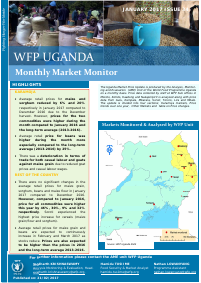

time: 444 ms


In [10]:
# Test
row = dataset[66000]
print(row)
dc = DocumentCover(doc_id=row['id'], cover_dir=row["cover_dir"], pdf_path=row['pdf_path'])
dc.standardize_size()
dc.cover

In [ ]:
NUM_JOBS = 40

pres = Parallel(n_jobs=NUM_JOBS)(delayed(parallel_process)(row) for row in dataset)

In [ ]:
# !ls -l /R/NLP/CORPUS/WB/cover | wc -l